In [187]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [189]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [190]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [191]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


In [192]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [193]:
df = df.drop(columns = ['Date','Code', 'Locale'])

In [194]:
df = df.drop(columns = ['SO2', 'CO','PM10','PM2_5'])

<AxesSubplot:>

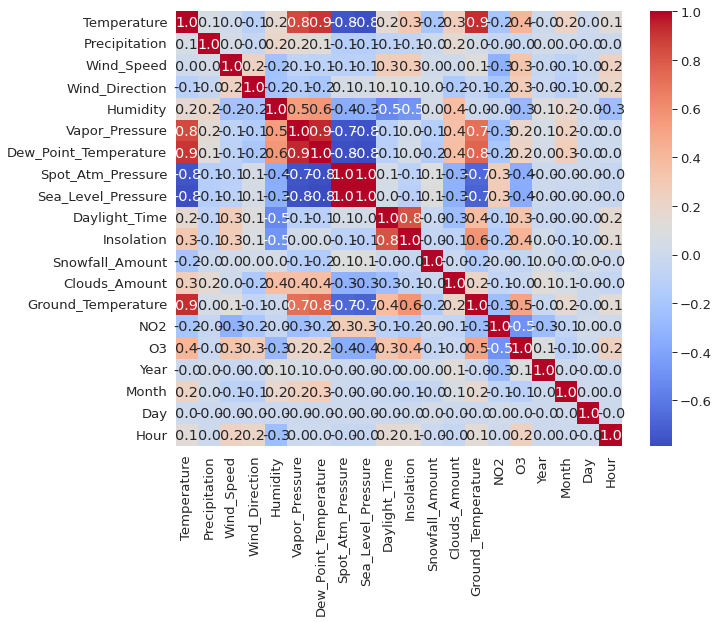

In [195]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [196]:
# Specify the target variable
y = df['O3']

In [197]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [198]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [199]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
# Determine the number of features you want to keep
k = 18  # This is just an example. Adjust based on your requirements.

# Initialize SelectKBest
selector = SelectKBest(score_func=f_regression, k=k)

# Fit on the training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Transform the test data
X_test_selected = selector.transform(X_test)

selected_features = [column for column, selected in zip(X_train.columns, selector.get_support()) if selected]
print("Selected Features:", selected_features)

feature_scores = selector.scores_
for score, feature_name in sorted(zip(feature_scores, X_train.columns), reverse=True):
    print(f"Feature: {feature_name}, Score: {score}")

Selected Features: ['Temperature', 'Precipitation', 'Wind_Speed', 'Wind_Direction', 'Humidity', 'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure', 'Sea_Level_Pressure', 'Daylight_Time', 'Insolation', 'Snowfall_Amount', 'Clouds_Amount', 'Ground_Temperature', 'NO2', 'Year', 'Month', 'Hour']
Feature: Ground_Temperature, Score: 19236.328912315617
Feature: NO2, Score: 18248.96172332937
Feature: Insolation, Score: 12306.961088235095
Feature: Temperature, Score: 11868.652010860134
Feature: Sea_Level_Pressure, Score: 8314.482155646661
Feature: Spot_Atm_Pressure, Score: 7930.202014975302
Feature: Wind_Speed, Score: 6727.713957796282
Feature: Daylight_Time, Score: 6616.485993308719
Feature: Humidity, Score: 5090.695289643584
Feature: Wind_Direction, Score: 4713.046990566125
Feature: Hour, Score: 3412.4007991509534
Feature: Dew_Point_Temperature, Score: 2816.6311690632256
Feature: Vapor_Pressure, Score: 2162.782420202248
Feature: Month, Score: 650.6490707131479
Feature: Year, Score: 

In [201]:
# Initialize Multiple Linear Regression model
model = LinearRegression()

In [202]:
# Fit the model
model.fit(X_train_selected, y_train)

LinearRegression()

In [203]:
# Make predictions
predictions = model.predict(X_test_selected)

In [204]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.012565


In [205]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.009137


In [206]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.571389


In [ ]:
df

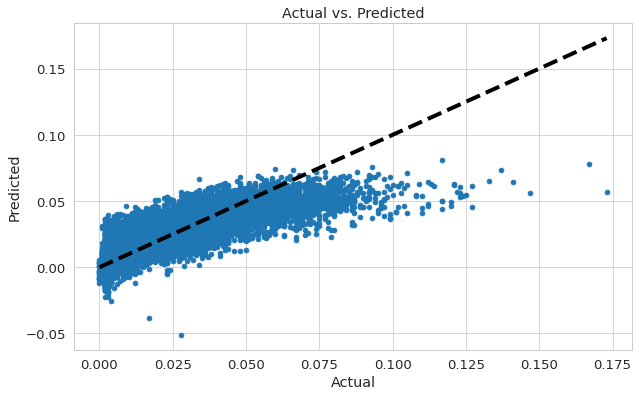

In [21]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

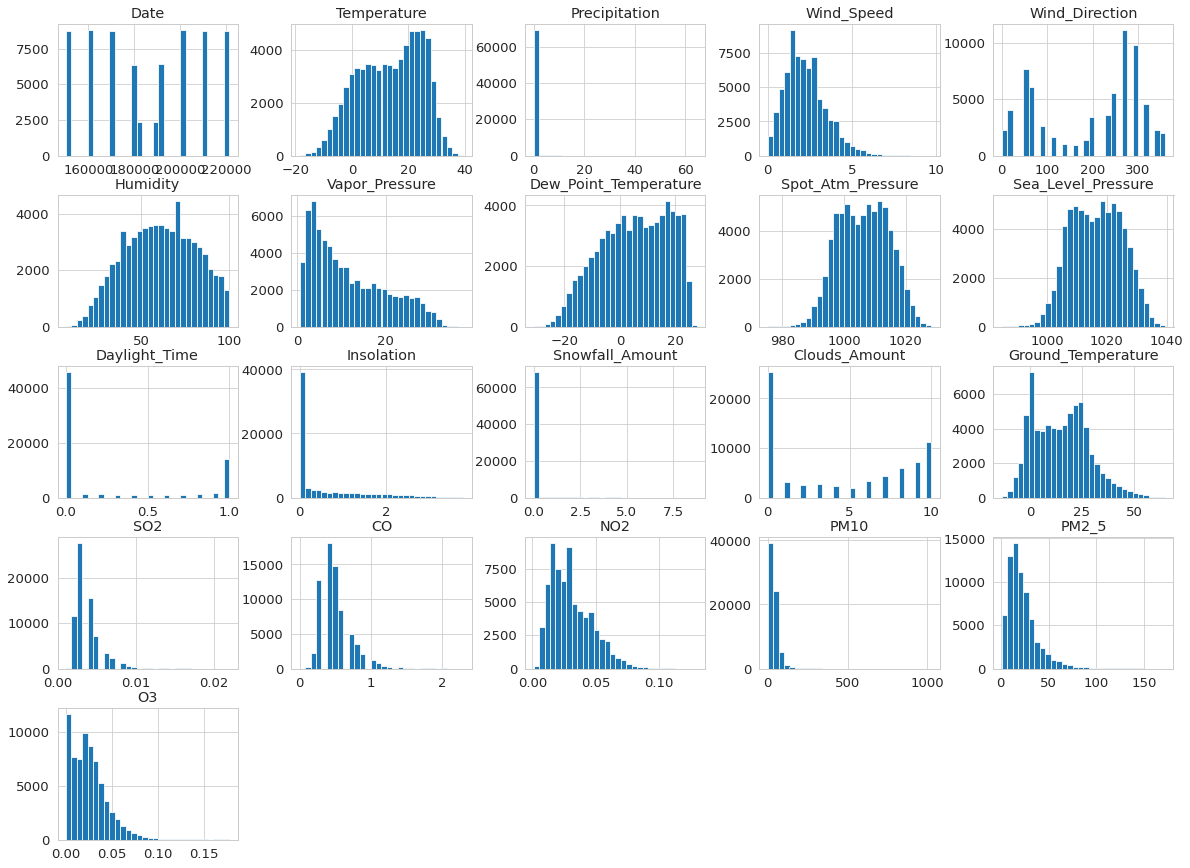

In [22]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

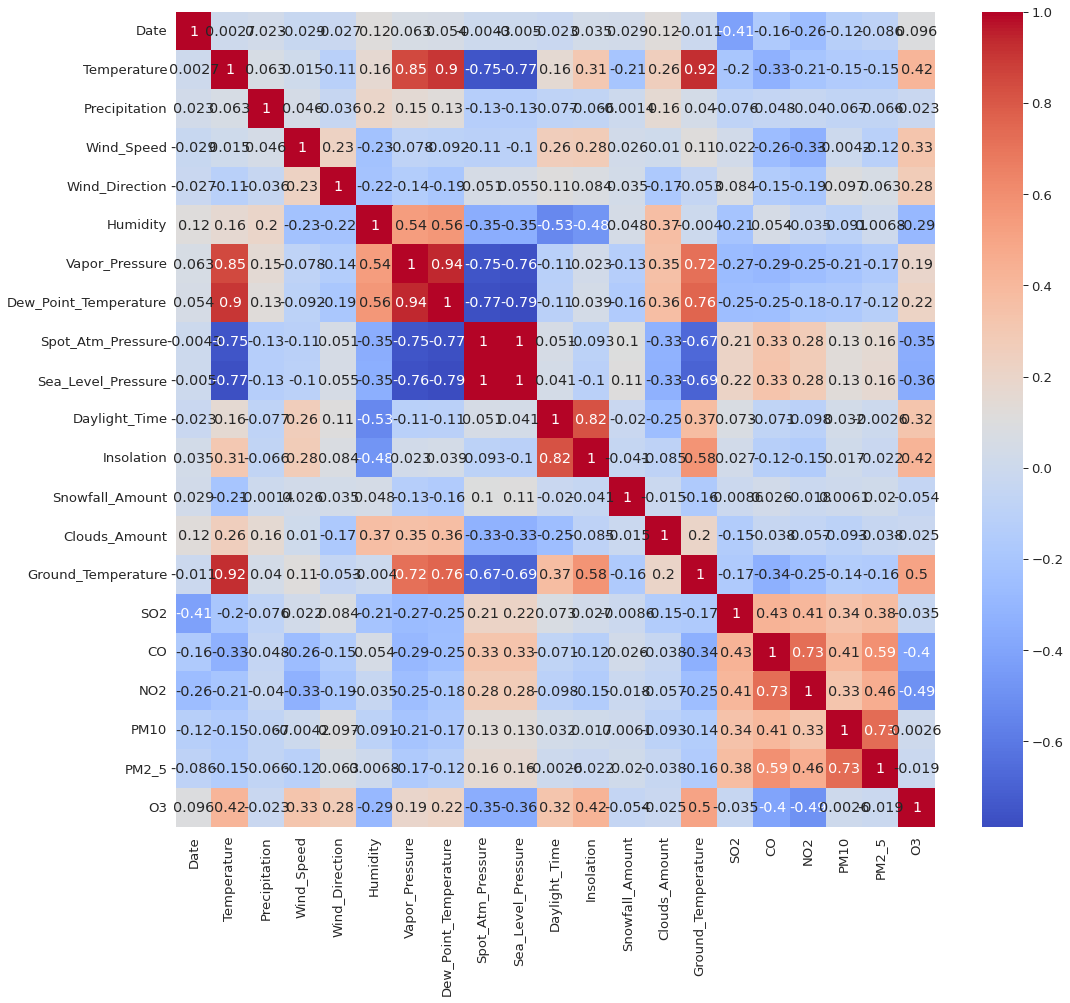

In [25]:
# Heatmap of Correlations
plt.figure(figsize=(17,15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

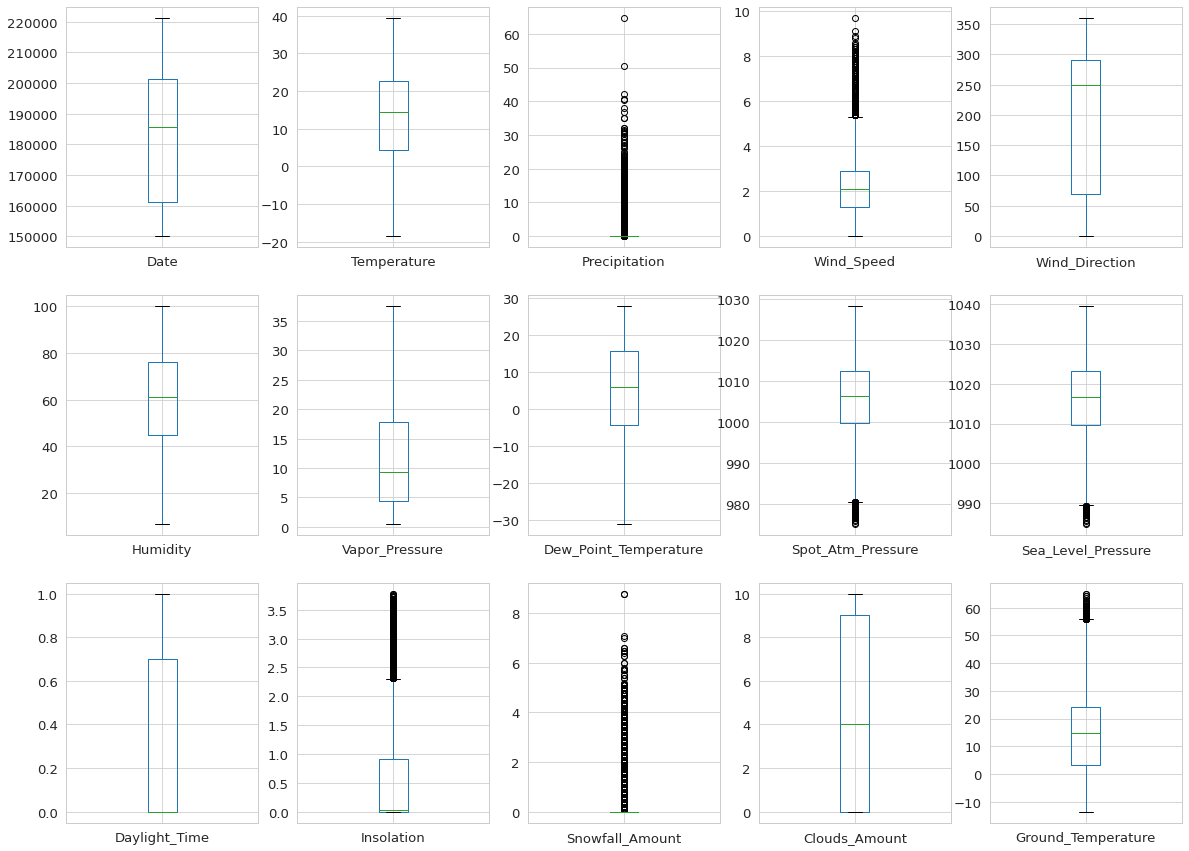

In [26]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()